These scripts are written for AnimalBiome (animalbiome.com).

This notebook was used to generate comparisons between individual pets and a range of animals of similar age in the data set. Data is from  the sequencing-based micribiome assessments AnimalBiome provides, it lists each microbe and it's proportion in the sample, identified to genus. The first file imported is metadata associated with each sample, which is used to find pets in a similar age range, and to filter out shelter animals.

In [1]:
#import libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#import metadata
df = pd.read_table('path/file.txt')
df.head()

,#SampleID,Name,Sex,City,State,Country,Age,SocializationStatus,FecalScore,weight,...,Urinary tract disease,Ringworm,Anxiety,Depression,Stress,Sleeps,nuCatsInHouse,nuDogsInHouse,otherAnimalsInHouse,Notes
0,1006,Starbuck,Male,San Mateo,CA,USA,2.0,House,4.0,12.0,...,0,0.0,0.0,0,0.0,Our bed or window perch,1,0.0,"My husband, human",NaN
1,1007,Jack,Male,Austin,TX,USA,7.0,House,1.0,14.0,...,0,0.0,0.0,0,0.0,my bed,1,0.0,NaN,NaN
2,1010,Meowskevitz,Female,Brooklyn,NY,USA,11.0,House,3.0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1,0.0,NaN,NaN
3,1011,Mimi,Female,Brooklyn,NY,USA,6.0,House,3.0,NaN,...,0,0.0,0.0,0,0.0,in human bed,1,0.0,NaN,NaN
4,1014,NaN,Female,Oxford,MS,USA,8.0,House,3.0,11.0,...,0,0.0,0.0,0,0.0,Perch near the window or foot of bed,1,1.0,"Dog, 1",NaN


In [4]:
#import taxonomic data from sequencing
otu = pd.read_table('path/QIIM_output_L6_taxonomy.txt')
otu.head()
#len(otu) 140

,#OTU_ID,1177,1508,1295,B122,1355,B67,1075,1124,1389bis,...,1204,1159,1330,B49,1123,1184,1164,1166,1180,1328
0,Unassigned;Other;Other;Other;Other;Other,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0008,0.0006,0.0,0.0
1,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0000,0.0,0.0
2,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.0006,0.0000,0.0000,0.0000,0.0,0.0004,0.0002,0.0,0.0000,...,0.0134,0.0008,0.0002,0.0002,0.0050,0.0004,0.0004,0.0004,0.0,0.0
3,k__Bacteria;p__Actinobacteria;c__Coriobacterii...,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
4,k__Bacteria;p__Actinobacteria;c__Coriobacterii...,0.0000,0.0004,0.0004,0.0004,0.0,0.0000,0.0000,0.0,0.0154,...,0.0000,0.0002,0.0000,0.0020,0.0002,0.0000,0.0014,0.0010,0.0,0.0


In [5]:
df2 = df.drop_duplicates("#SampleID")
len(df2)

323

In [7]:
#Calculating diversity values for a target cat (fed into the plot below as axvline)

catID = '1473'
targetData = df2[(df2['#SampleID'] == catID)]

ageTarget = targetData['Age']
print ('Age: %d' % ageTarget)

#Species Richness
cat = otu[['#OTU_ID', catID]]
cat1 = cat[cat[catID] > 0]
richnessTarget = len(cat1)
print ('Richness: %f' % richnessTarget)

#Shannon's Diversity
cat2 = cat1.sort_values([catID], ascending = False)
cat2['ln_prop'] = np.log(cat2[catID])
cat2['pi*ln(pi)'] = cat2[catID] * cat2['ln_prop']
shannonTarget = -sum(cat2['pi*ln(pi)'])
print ('Shannon Diversity: %f' % shannonTarget)

#top 5 most common bacteria in the target cat
cat3 = cat2.iloc[0:5, :2]
cat3.to_csv('path/sampleID_top5.csv')
print cat3

Age: 1
Richness: 25.000000
Shannon Diversity: 2.082625
                                              #OTU_ID    1473
63  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...  0.2580
61  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...  0.2408
6   k__Bacteria;p__Actinobacteria;c__Coriobacterii...  0.1384
80  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...  0.1344
10  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...  0.0722


In [8]:
#Finding a group of similar cats to target cat
#Here will be a unique query for each cat, depending on their metadata
#Because the target cat is 1 yr old, I filtered for young cats and filtered out animals
#from the shelter (using SocializationStatus)

simCats =  df2[ (df2['Age'] >= 1) & (df2['Age'] < 5) & (df2['SocializationStatus'] == 'House')]
similarCats = simCats['#SampleID']
len(similarCats)

39

In [9]:
#calculating diversity averages for the similar cats (Shannon's Diversity Index and 
#Species Richness)

richness_all = []
shannon_all = []
evenness_all = []

for num in similarCats:
    try:

        #selecting out the data 
        cat_all = otu[['#OTU_ID', num]]
        cat1_all = cat_all[cat_all[num] > 0]

        #Richness        
        richnessSimilar = len(cat1_all)
        richness_all.append(richnessSimilar)
    
        #Shannon's Diversity
        cat2_all = cat1_all.sort_values([num], ascending = False)
        cat2_all['ln_prop'] = np.log(cat2_all[num])
        cat2_all['pi*ln(pi)'] = cat2_all[num] * cat2_all['ln_prop']
        shannonSimilar = -sum(cat2_all['pi*ln(pi)'])
        shannon_all.append(shannonSimilar)
        
        #top 5 most common bacteria across similar cats
        cat3_all = cat2_all.iloc[0:5, :2]
        cat3_all.to_csv('path/similarAnimals_top5.csv')
    
    except:
        continue
    
numberCats = len(richness_all)        
richness_ave = sum(richness_all)/numberCats
richness_sd = np.std(richness_all)
shannon_ave = float(sum(shannon_all)/numberCats)
shannon_sd = np.std(shannon_all)

print ('Number of similar cats: %i' % numberCats) 
print ('Average richness: %r, standard deviation: %f' % (richness_ave, richness_sd))
print ('Average Shannon Diversity: %f, standard deviation: %f' % (shannon_ave, shannon_sd))

Number of similar cats: 36
Average richness: 33, standard deviation: 6.850870
Average Shannon Diversity: 1.770535, standard deviation: 0.537587


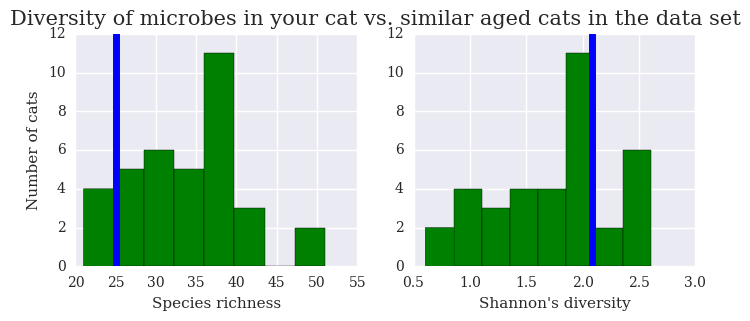

In [11]:
#Create figure
fig = plt.figure()
fig.set_size_inches(8, 3)
sns.set(font='serif')

ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
#ax3=fig.add_subplot(133)

#Species Richness
ax1.hist(richness_all, color = 'g', bins = 8, label='Similar cats')
ax1.set_xlabel("Species richness")
ax1.set_ylabel("Number of cats")
ax1.axvline(richnessTarget, color='b', linestyle='solid', linewidth=5)

#Shannon's Diversity 
ax2.hist(shannon_all, color='g', bins=8, label='Similar cats')
ax2.set_xlabel("Shannon's diversity")
ax2.axvline(shannonTarget, color='b', linestyle='solid', linewidth=5)

fig.suptitle('Diversity of microbes in your cat vs. similar aged cats in the data set', fontsize=15)
fig.savefig('path/file.png', bbox_inches='tight')